In [ ]:
# !pip install tensorflow-datasets
!pip install -U tfds-nightly --user
# !pip install tensorflow-gpu

In [ ]:
# print(tf.__version__)
# !pip install tensorflow==2.* --user

In [ ]:
# !pip install -U --pre tensorflow=="2.1"
!pip install tf_slim

In [ ]:
!pip install pycocotools

In [ ]:
# !pip install tensorflow==2.1
# !pip install six

In [ ]:
import numpy as np
import os
import six
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [ ]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
pip install .

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
import tensorflow_datasets as tfds


In [ ]:
# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

In [ ]:
# !gcloud auth login application-default



In [ ]:
!gcloud config set account application-default

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !gcloud auth login dissertation-0




In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
#     shuffle_files=True,
    # as_supervised=True,
#     try_gcs=True,
    with_info=True,
    download=False,
#     data_dir='./tensorflow_datasets'
    data_dir="gs://kitti-dataset-1"
)

# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets')


In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [ ]:

# model_name = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
# model_name = 'ssd_inception_v2_coco_2018_01_28'
model_name = 'faster_rcnn_resnet50_lowproposals_coco_2018_01_28'
# model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
# model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
# model_name = 'faster_rcnn_nas_lowproposals_coco_2018_01_28'
detection_model = load_model(model_name)


In [ ]:
# List of the strings that is used to add correct label for each box.

# PATH_TO_LABELS = 'models/research/object_detection/data/kitti_label_map.pbtxt'
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [ ]:
# ds_train =ds 

In [ ]:
def normalize_img(object):
  print(object['objects'])
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(object['image'], tf.float32) / 255., object['objects']['bbox']



In [ ]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_train

In [ ]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(detection_model.inputs)



In [ ]:
detection_model.output_dtypes

In [ ]:
detection_model.output_shapes

## Output format


- Output classes are always integers in the range 0, num_classes). Any mapping of these integers to semantic labels is to be handled outside of this class. We never explicitly emit a “background class” --- thus 0 is the first non-background class and any logic of predicting and removing implicit background classes must be handled internally by the implementation.


- Detected boxes are to be interpreted as being in (y_min, x_min, y_max, x_max) format and normalized relative to the image window.

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def norm(data):
    height= 375
    width = 1242
    
    data['xmin'] = data['xmin'] / width 
    data['xmax'] = data['xmax'] / width
    data['ymin'] = (height - data['ymin']) / height
    data['ymax'] = (height - data['ymax']) / height
    
    return data

In [ ]:
import pandas as pd
import numpy as np
import time

# import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tqdm.keras import TqdmCallback



# ----------- import data and scaling ----------- #
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']]
y_train = df_train[['xloc', 'yloc','zloc']].values

X_test = df_test[['xmin', 'xmax', 'ymin','ymax']].values
y_test = df_test[['xloc', 'yloc','zloc']].values

#  ymin=(height - bbox.bottom) / height,
#       ymax=(height - bbox.top) / height,
#       xmin=bbox.left / width,
#       xmax=bbox.right / width,
# 375 ,1242
# standardized data
# xScalar = StandardScaler()
# yScalar = StandardScaler()
# X_train = xScalar.fit_transform(X_train)
# y_train = yScalar.fit_transform(y_train)

X_train = norm(X_train).values

In [ ]:
# X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']].values

print(X_train[:10])

# X_train = norm(X_train)
# X_train[:10]


In [ ]:
# TRAINING MODE


# ----------- create model ----------- #
model = keras.Sequential()
model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal'))


# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='mean_squared_error',optimizer='adam')

# ----------- define callbacks ----------- #
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                verbose=1, min_delta=1e-4, mode='min')
modelname = "model@{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(modelname))

# ----------- start training ----------- #
history = model.fit(X_train, y_train,
            validation_split=0.1, epochs=10000, batch_size=8000,verbose=0, callbacks=[tensorboard, TqdmCallback(verbose=1)])


# ----------- save model and weights ----------- #
model_json = model.to_json()
with open("generated_files/{}.json".format(modelname), "w") as json_file:
   json_file.write(model_json)

model.save_weights("generated_files/{}.h5".format(modelname))
print("Saved model to disk")



In [ ]:
pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


In [ ]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
# INFERENCE MODE

from tensorflow.keras.models import model_from_json

df_test = pd.read_csv('data/test.csv')
X_test = df_test[['xmin', 'xmax', 'ymin','ymax']]
y_test = df_test[['xloc' ,'yloc','zloc']].values

# standardized data
# scalar = MinMaxScaler()
# X_test = scalar.fit_transform(X_test)
# y_test = yScalar.fit_transform(y_test)
    
X_test = norm(X_test).values
print(X_test[:10])

# MODEL = "model@1595813111"
# WEIGHTS = "model@1595813111"

MODEL = modelname
WEIGHTS = modelname


# load json and create model
json_file = open('generated_files/{}.json'.format(MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights("generated_files/{}.h5".format(WEIGHTS))
print("Loaded model from disk")

# loaded_model = model
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test)


# scale up predictions to original values
# y_pred_transformed = yScalar.inverse_transform(y_pred)
# y_test_transformed = yScalar.inverse_transform(y_test)

# y_pred_transformed = y_pred
# save predictions
df_result = df_test
df_result['zloc_pred'] = -100000
df_result['xloc_pred'] = -100000


for idx, row in df_result.iterrows():
    df_result.at[idx, 'zloc_pred'] = y_pred[idx][2]
    df_result.at[idx, 'xloc_pred'] = y_pred[idx][0]

df_result.to_csv('data/predictions2.csv', index=False)

In [ ]:

def run_locnet( bboxes):
  
    if len(bboxes)==0 or len(bboxes)==1 and not any(bboxes[0]):
        return []
#     bboxes = xScalar.transform(bboxes)
    y_pred = loaded_model.predict(bboxes)
    # scale up predictions to original values
#     y_pred_transformed = yScalar.inverse_transform(y_pred)

    return y_pred
#     return y_pred_transformed

In [ ]:
def transform_to_kitti(classes):
    
    hash = { 3:1 , 8:3, 1:4, 7:7 }
    retudef filter_detections( output_dict):
    
    output_dict['detection_classes'] = transform_to_kitti(output_dict['detection_classes'])
    
#     print(output_dict  )
    misc_ids = (8,9)
    
    scores = output_dict['detection_scores']
    classes = output_dict['detection_classes']
    
    size = len(classes)
    min_threshhold = 0.5
    output_dict['detection_boxes'] = np.array([ output_dict['detection_boxes'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])
    output_dict['detection_classes'] = np.array([ output_dict['detection_classes'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])
    output_dict['detection_scores'] = np.array([ output_dict['detection_scores'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])


    return output_dictrn [ hash.get(classes[i], 8) for i in range(len(classes)) ]

In [ ]:
def filter_detections( output_dict):
    
    output_dict['detection_classes'] = transform_to_kitti(output_dict['detection_classes'])
    
#     print(output_dict  )
    misc_ids = (8,9)
    
    scores = output_dict['detection_scores']
    classes = output_dict['detection_classes']
    
    size = len(classes)
    min_threshhold = 0.5
    output_dict['detection_boxes'] = np.array([ output_dict['detection_boxes'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])
    output_dict['detection_classes'] = np.array([ output_dict['detection_classes'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])
    output_dict['detection_scores'] = np.array([ output_dict['detection_scores'][i] for i in range(size) if scores[i] >= min_threshhold and classes[i] not in misc_ids  ])


    return output_dict

In [116]:
def scale_up_boxes( output_dict):
    
    output_dict['detection_boxes'] = output_dict['detection_boxes'] * 1000

    return output_dict

In [ ]:
!pip install filterpy

In [ ]:
# initialize Sort object and video capture
from sort import *
mot_tracker = Sort()

In [ ]:
def format_detections_for_mot(outputdict):
    
    detections = [ np.append(outputdict['detection_boxes'][i] , outputdict['detection_scores'][i])  for i in range( len(outputdict['detection_classes'])) ] 
    
    return np.asarray(detections)  if len(detections) else np.empty((0, 5))


In [225]:
def format_boxes( boxes):
    
    result = boxes.numpy()
    for box in result:
        box[0]=1-box[0]
        box[2]=1-box[2]
        box[0],box[2] = box[2], box[0]
    return tf.convert_to_tensor(result)

In [ ]:
def process_image(image):
  

    image_np = np.copy(image) #TODO: make more efficent 
    
    output_dict = run_inference_for_single_image(detection_model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=1)
    
    output_dict =filter_detections( output_dict)

    locations = run_locnet( output_dict['detection_boxes'])
    
    detections = format_detections_for_mot(output_dict)
    
#     print( 'detections', detections)
    tracked_objects = mot_tracker.update(detections)
    
    print("Tracked objects: " , tracked_objects)
    
#     print( "distance_vector")

#     print( locations)

#     vis_util.draw_bounding_box_on_image_array(image_np, xmin, ymin, xmax, ymax, thickness=1, display_str_list=[distance])
    
    return image_np

In [ ]:
run_locnet( [[0.41085333,0.4335749 ,0.5223467 ,0.4712963 ]])

In [ ]:

# Load the TensorBoard notebook extension
# %reload_ext tensorboard


%tensorboard --logdir logs


In [ ]:
%reload_ext tensorboard

In [ ]:
!pip install tensorboard 

In [ ]:
def show_inference(model, tensor):
  
  
    image_np = np.array(tensor)
    image =process_image(image_np)
    display(Image.fromarray(image))
    return

In [ ]:
for example in ds_test.take(3):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
    print('bbox:' ,objects['bbox'])
    print('location:', objects['location'])
    print('type:', objects['type'])
    show_inference(detection_model, image)




## Notes on bbox from tfds

bbox: tf.Tensor of type `tf.float32` and shape `[4,]` which contains the
      normalized coordinates of the bounding box `[ymin, xmin, ymax, xmax]`

[[0.47765332 0.4335749  0.5891467  0.4712963 ]]
detboxes:  [[0.48387626 0.43768257 0.58862966 0.47398788]]


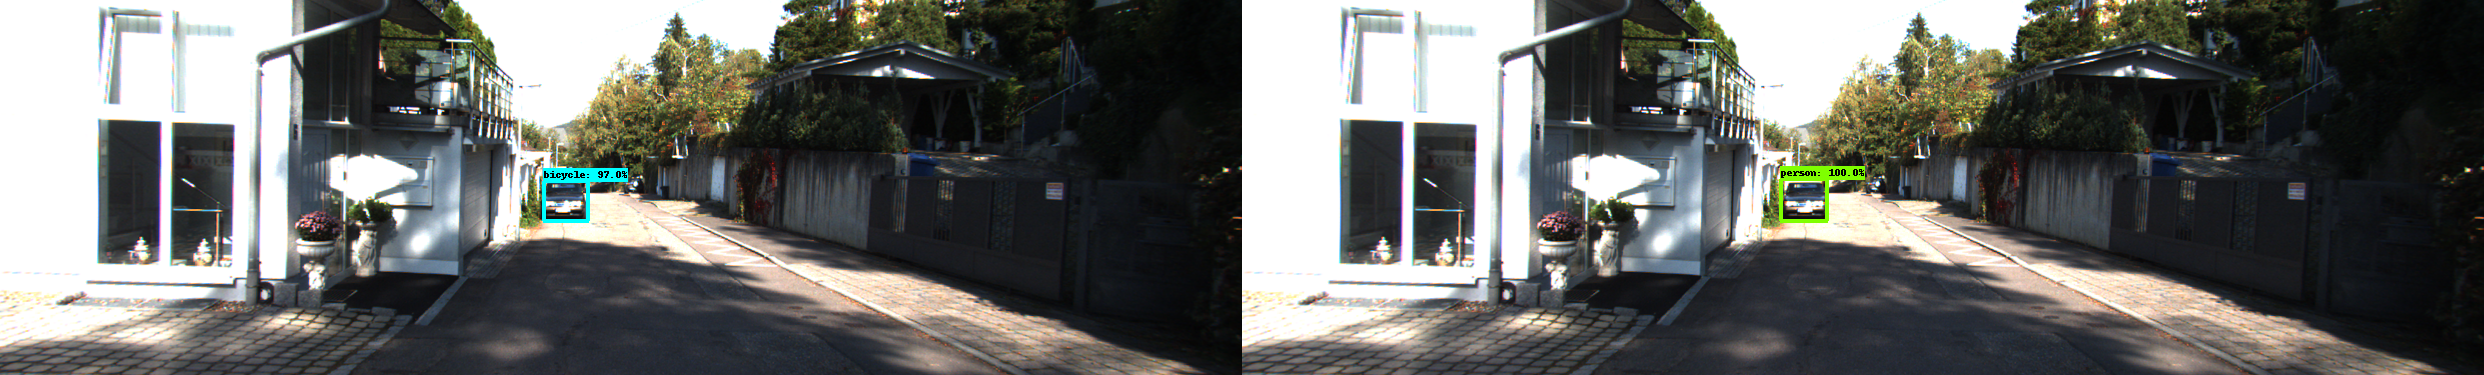

[[0.47962767 0.4600161  0.5580585  0.48607576]
 [0.53710103 0.         0.99734044 0.24649476]
 [0.49321806 0.14333601 0.6974734  0.26334408]
 [0.4913032  0.23475423 0.63319147 0.31551167]
 [0.35345745 0.2977921  0.6673936  0.39928284]
 [0.48994678 0.38484287 0.5830851  0.42310235]
 [0.49148935 0.4031265  0.5589894  0.4305963 ]
 [0.48710108 0.05693795 0.67539895 0.18574537]]
detboxes:  [[0.53940815 0.         0.9943958  0.24312885]
 [0.49397543 0.45765543 0.5695299  0.48794532]
 [0.49874336 0.15145287 0.67452246 0.25724834]
 [0.50942    0.24032071 0.63856083 0.29516235]
 [0.4966944  0.39720145 0.58782375 0.419333  ]
 [0.49755853 0.06267206 0.57674104 0.1647056 ]
 [0.49424988 0.4092191  0.5716384  0.4266972 ]
 [0.366498   0.30530226 0.6669575  0.3969558 ]]


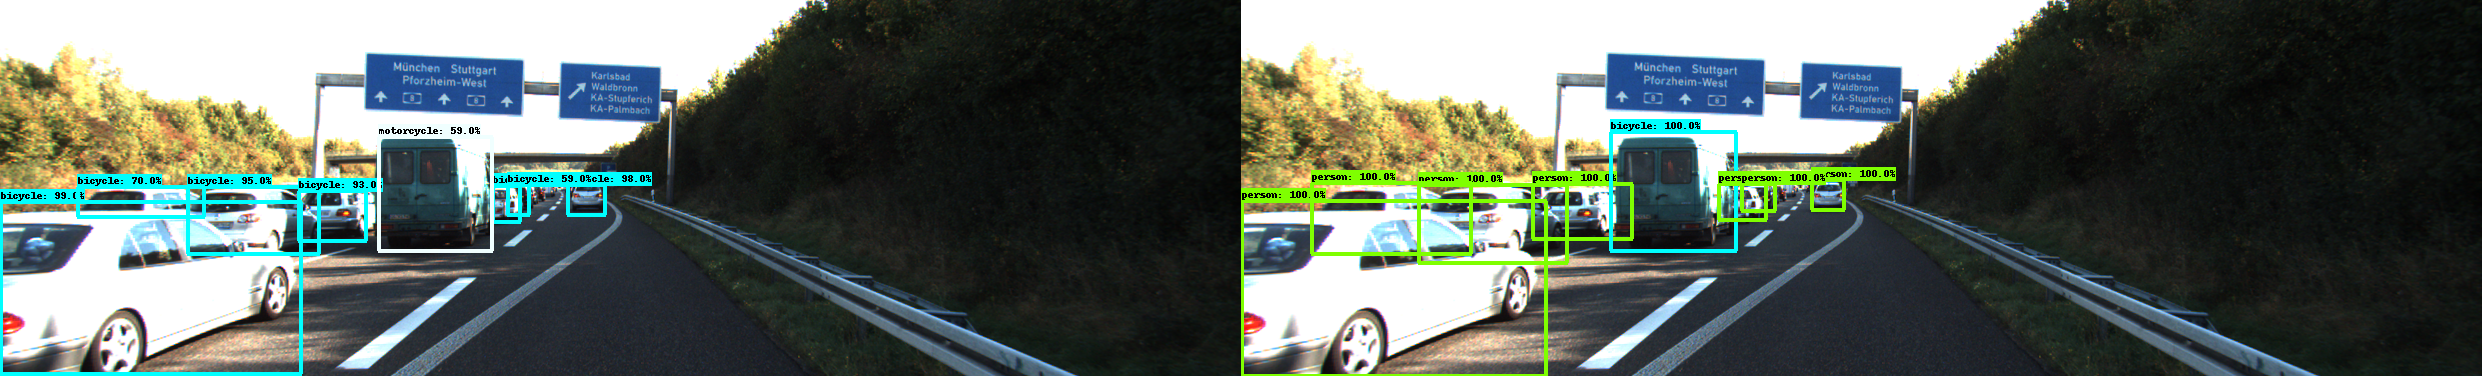

[[0.40453333 0.5000725  0.51104    0.5558535 ]
 [0.5126667  0.02500805 0.76882666 0.20439613]
 [0.40677333 0.7859823  0.58610666 0.8263446 ]]
detboxes:  [[0.52162343 0.0287208  0.7495469  0.19711593]
 [0.41951883 0.80022466 0.5691587  0.82226646]
 [0.4768984  0.2913467  0.54140794 0.32672873]
 [0.4395767  0.6495108  0.52557534 0.65756696]
 [0.43850285 0.64772797 0.5250343  0.655233  ]
 [0.43875915 0.6411834  0.5222097  0.6490214 ]]


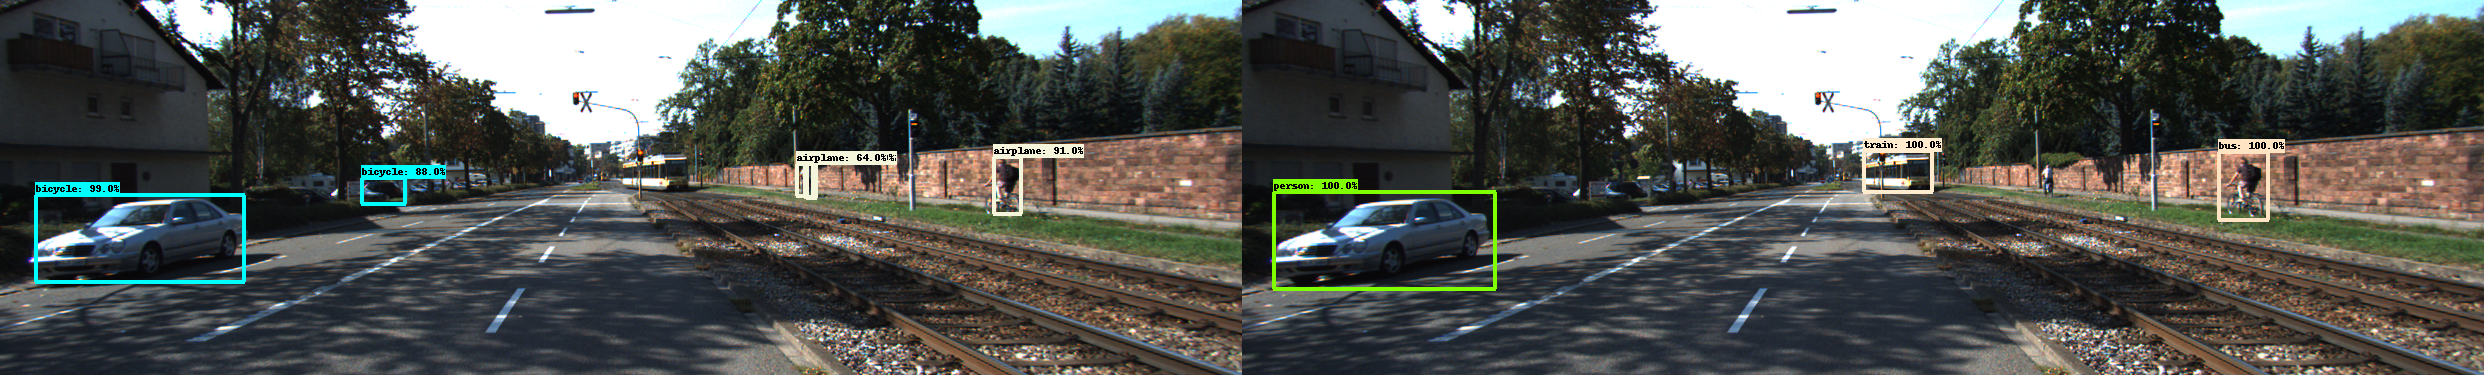

[[0.45490664 0.5752093  0.4937867  0.58990335]]
detboxes:  []


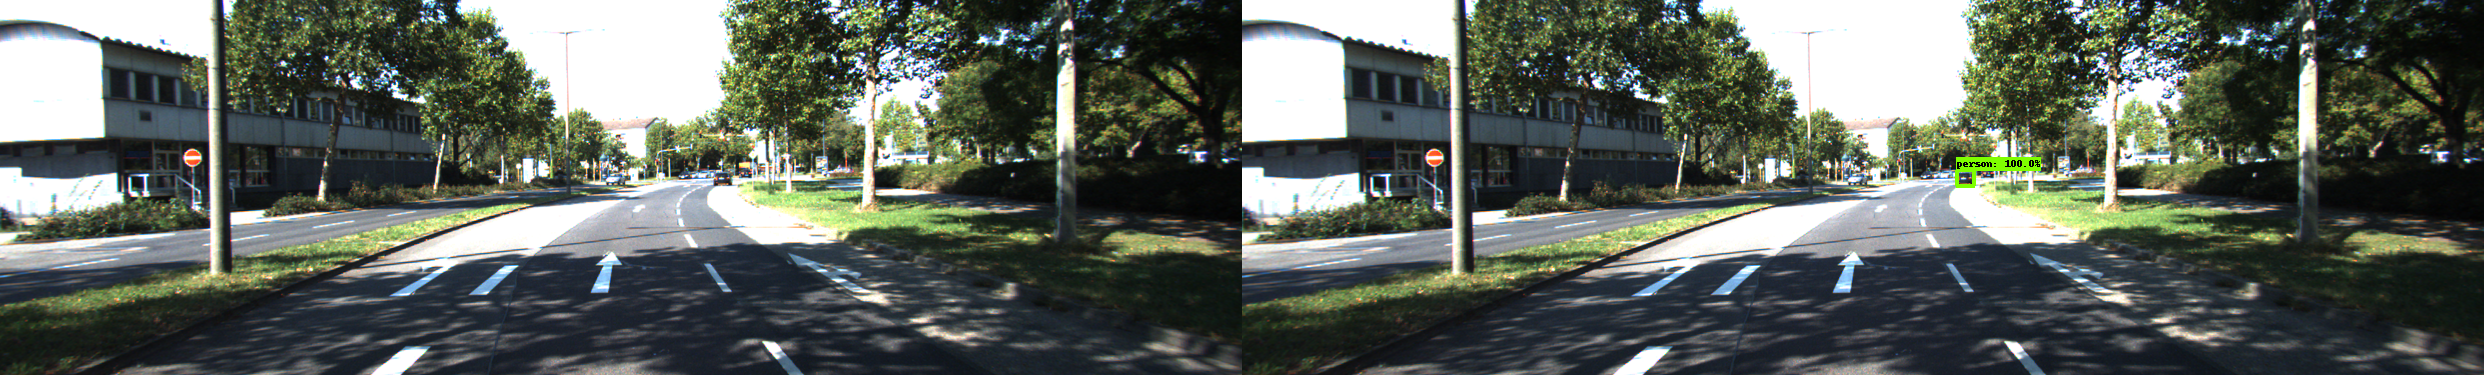

[[0.49512    0.48723027 0.54010665 0.5021095 ]]
detboxes:  [[0.5144687 0.4967103 0.5593846 0.5386218]]


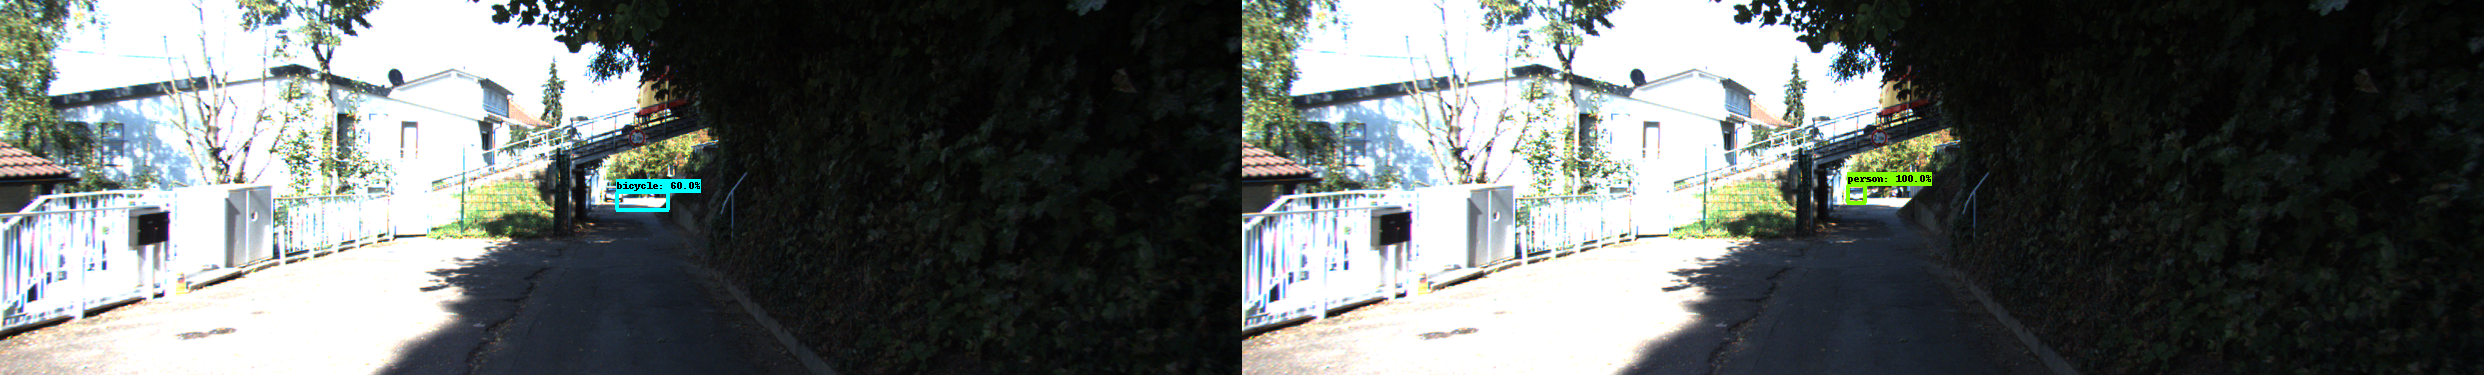

In [232]:
#TODO: Complete Evaluation steps

from object_detection import eval_util
from object_detection.core import standard_fields as fields
from object_detection.metrics import coco_evaluation
from object_detection.protos import eval_pb2
from object_detection.utils import test_case
from object_detection.utils import tf_version

input_data_fields = fields.InputDataFields
detection_fields = fields.DetectionResultFields


for example in ds_test.take(5):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    objects = example["objects"]
#     show_inference(detection_model, image)
    image_np = np.array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(detection_model, image_np)


    output_dict = filter_detections( output_dict)

    batch_size = 1
    key=tf.constant('image1')
    
    groundtruth_boxes = format_boxes(objects['bbox'])
    groundtruth_classes = objects['type']+1
    groundtruth = {
        input_data_fields.groundtruth_boxes: groundtruth_boxes,
        input_data_fields.groundtruth_classes: groundtruth_classes,      
    }
    
    num_detections = tf.constant([len(output_dict['detection_classes'])])
    
    detections = {
        detection_fields.detection_boxes: tf.constant([output_dict['detection_boxes']]) ,
        detection_fields.detection_scores: tf.constant([output_dict['detection_scores']]),
        detection_fields.detection_classes: tf.constant([output_dict['detection_classes']]),
        detection_fields.num_detections: num_detections
       
    }
    

    image = tf.constant([image_np])
    
    
    print( "detboxes: ", output_dict['detection_boxes'])

    result_dict = eval_util.result_dict_for_single_example(image, key,detections, groundtruth)
    
#     result_dict2 = {k: v.numpy() for k, v in result_dict.items()}
    side_by_side_img =  vis_util.draw_side_by_side_evaluation_image(result_dict,category_index)[0][0].numpy()
    display(Image.fromarray(side_by_side_img))
#     test_get_eval_metric_ops_for_coco_detections(result_dict)
#     test_get_estimator_eval_metric_ops(result_dict)

1

In [136]:
result_dict

{'original_image': <tf.Tensor: shape=(1, 375, 1242, 3), dtype=int32, numpy=
 array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  12,  10],
          [  8,  11,  10],
          [  7,  10,  10]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  12,  10],
          [  7,  11,  10],
          [  6,  10,  10]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  13,  11],
          [  7,  11,  10],
          [  7,   9,  10]],
 
         ...,
 
         [[ 71,  58,  50],
          [ 74,  61,  52],
          [ 75,  69,  55],
          ...,
          [ 14,  13,  12],
          [ 14,  13,  11],
          [ 14,  13,  13]],
 
         [[ 75,  85, 101],
          [ 76,  92, 102],
          [ 75,  99, 106],
          ...,
          [ 14,  15,  17],
          [ 14,  15,  16],
          [ 14,  14,  16]],
 
        

In [ ]:
#TODO: Complete Evaluation steps
from object_detection.core import standard_fields
from object_detection.utils import object_detection_evaluation


categories = [{
        'id': 1,
        'name': 'car'
    }, {
        'id': 2,
        'name': 'van'
    }, {
        'id': 3,
        'name': 'truck'
    }, {
        'id': 4,
        'name': 'pedestrian'
    }]

print( categories)
pascal_evaluator = object_detection_evaluation.PascalDetectionEvaluator(
        categories)

for index, example in enumerate(ds_test.take(100)):  
    image = example["image"]
    objects = example["objects"]
  
#     show_inference(detection_model, image)
    image_np = np.array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(detection_model, image_np)
    


    output_dict = filter_detections( output_dict)
    
#     output_dict = scale_up_boxes( output_dict)
    
    image_key = 'img'+str(index)
    

#     groundtruth_boxes = objects['bbox'].numpy()
    groundtruth_boxes = format_boxes(objects['bbox']).numpy()
    groundtruth_classes = objects['type'].numpy()+1
    
    print( 'ground_truth_classes' ,  groundtruth_classes)
    print( 'ground_truth_boxes' ,  groundtruth_boxes)
    print( 'detection_classes' ,  output_dict['detection_classes'])
    print( 'detection_boxes' ,  output_dict['detection_boxes'])
    print( 'detection_scores' ,  output_dict['detection_scores'])
    
    print( '*'*100)



    pascal_evaluator.add_single_ground_truth_image_info(
        image_key,
        {standard_fields.InputDataFields.groundtruth_boxes: groundtruth_boxes,
         standard_fields.InputDataFields.groundtruth_classes:
         groundtruth_classes,
#          standard_fields.InputDataFields.groundtruth_difficult:
#          groundtruth_is_difficult_list2
        })

    if len(output_dict['detection_classes']):
        pascal_evaluator.add_single_detected_image_info(
                image_key,
                {standard_fields.DetectionResultFields.detection_boxes: output_dict['detection_boxes'],
                 standard_fields.DetectionResultFields.detection_scores:
                 output_dict['detection_scores'],
                 standard_fields.DetectionResultFields.detection_classes:
                 output_dict['detection_classes']
                })
    

    metrics = pascal_evaluator.evaluate()
    
    


In [129]:
output_dict

{'detection_classes': array([1]),
 'detection_boxes': array([[0.48387626, 0.43768257, 0.58862966, 0.47398788]], dtype=float32),
 'detection_scores': array([0.971274], dtype=float32),
 'num_detections': 5}

In [230]:
metrics

{'PascalBoxes_Precision/mAP@0.5IOU': 0.319511388036129,
 'PascalBoxes_PerformanceByCategory/AP@0.5IOU/car': 0.6327162326772654,
 'PascalBoxes_PerformanceByCategory/AP@0.5IOU/van': 0.0,
 'PascalBoxes_PerformanceByCategory/AP@0.5IOU/truck': 0.034482758620689655,
 'PascalBoxes_PerformanceByCategory/AP@0.5IOU/pedestrian': 0.6108465608465609}

In [ ]:
!pip install moviepy proglog

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/accident_compilation.mp4 accident_compilation.mp4

In [ ]:
!ls -sh accident_compilation.mp4

In [ ]:
from moviepy.editor import VideoFileClip
import proglog
proglog.notebook()

write_output = 'output_' + model_name + '.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first n seconds
# clip1 = VideoFileClip("test.mp4").subclip(0,1)

# clip1 = VideoFileClip("test.mp4")

clip1 = VideoFileClip("accident_compilation.mp4").subclip(20,21)


white_clip = clip1.fl_image(process_image) 

white_clip.write_videofile(write_output, audio=False, verbose=False)

clip1.close()


In [ ]:
!pip install tf-models-official --user

In [ ]:
# !python models/research/object_detection/legacy/eval.py --pipeline_config_path=gs://hazard-detection-test-videos/job_dir/pipeline.config  --checkpoint_dir=gs://hazard-detection-test-videos/job_dir --eval_dir=gs://hazard-detection-test-videos/eval_dir

In [ ]:
!python models/research/object_detection/model_main.py --pipeline_config_path=pipeline.config  --checkpoint_dir=checkpoint_dir --model_dir=eval_dir            

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/tf2model/* ./

In [ ]:
!ls checkpoint_dir

## LocNet starts
